In [30]:
import pandas as pd

import data 

In [31]:
# 1. Reload the data
df = pd.read_csv('customer_churn_clean.csv')

print(df.dtypes)
print("\nMissing values:\n", df.isnull().sum())


customerid           object
gender               object
seniorcitizen         int64
partner               int64
dependents            int64
tenure                int64
phoneservice          int64
multiplelines        object
internetservice      object
onlinesecurity       object
onlinebackup         object
deviceprotection     object
techsupport          object
streamingtv          object
streamingmovies      object
contract             object
paperlessbilling      int64
paymentmethod        object
monthlycharges      float64
totalcharges        float64
churn                 int64
dtype: object

Missing values:
 customerid          0
gender              0
seniorcitizen       0
partner             0
dependents          0
tenure              0
phoneservice        0
multiplelines       0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
contract            0
paperlessbilling    0
paymen

HOT ENCODING 

In [32]:
import pandas as pd
from sklearn.model_selection import train_test_split

# --- Helper function: find a column ignoring case and underscores ---
def _find_col(df: pd.DataFrame, name: str):
    name_norm = name.strip().lower().replace("_", "")
    for c in df.columns:
        c_norm = c.strip().lower().replace("_", "")
        if c_norm == name_norm:
            return c
    return None

# 0) Load your cleaned CSV file
df = pd.read_csv("customer_churn_clean.csv")

# 1) Drop customer ID column if it exists
# (In your dataset it may be 'customerid' in lowercase)
df_ml = df.drop(columns=["customerID", "customerid"], errors="ignore")

# 2) One-Hot Encoding
# Convert categorical (text) columns into numeric dummy variables
# drop_first=True avoids multicollinearity (dummy variable trap)
df_ml = pd.get_dummies(df_ml, drop_first=True)

# 3) Separate Features (X) and Target (y)
# After encoding, the target might be:
# - 'Churn_Yes' (if original was Yes/No)
# - 'churn' (if already numeric 0/1)
target_col = None
for candidate in ["Churn_Yes", "churn_Yes", "churn", "Churn"]:
    target_col = _find_col(df_ml, candidate)
    if target_col is not None:
        break

if target_col is None:
    available = ", ".join(list(df_ml.columns)[:50])
    raise KeyError(
        f"Target column not found. Tried ['Churn_Yes','churn_Yes','churn','Churn']. "
        f"Available columns (sample): {available}"
    )

# Features (independent variables)
X = df_ml.drop(columns=[target_col])

# Target (dependent variable)
y = df_ml[target_col]

# 4) Train-Test Split
# 80% for training, 20% for testing
# stratify=y keeps the same churn ratio in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Target column:", target_col)
print("X shape:", X.shape)
print("y shape:", y.shape)
print("Training set:", X_train.shape)
print("Test set:", X_test.shape)

Target column: churn
X shape: (7043, 30)
y shape: (7043,)
Training set: (5634, 30)
Test set: (1409, 30)


imbalance

In [33]:
!pip install -U imbalanced-learn scikit-learn

In [34]:
# --- Dealing with Class Imbalance (73% vs 27%) ---

from imblearn.over_sampling import SMOTE

# Apply SMOTE ONLY to the training data
# This creates synthetic samples for the minority class (churn = 1)
sm = SMOTE(random_state=42)

X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("Before SMOTE:")
print(y_train.value_counts())

print("\nAfter SMOTE:")
print(y_train_res.value_counts())

print(f"\nNow we have {len(y_train_res)} training examples.")

Before SMOTE:
churn
0    4139
1    1495
Name: count, dtype: int64

After SMOTE:
churn
0    4139
1    4139
Name: count, dtype: int64

Now we have 8278 training examples.


The confusion matrix (with SMOTE)

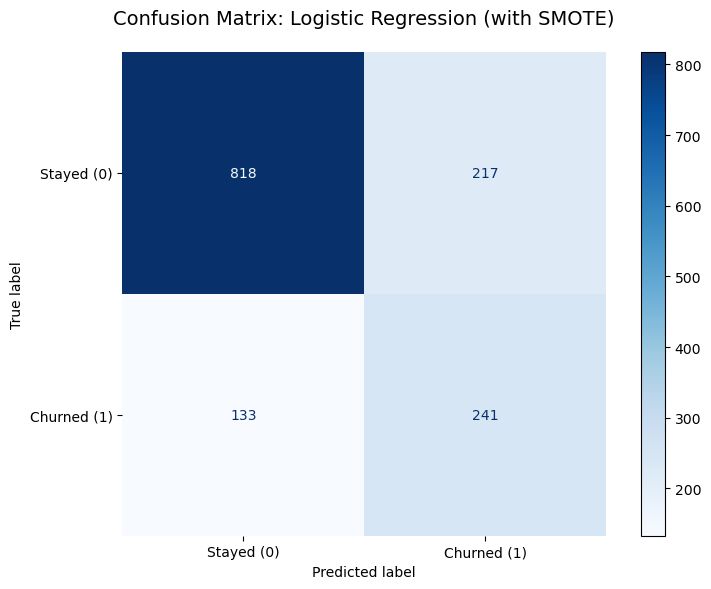


           SMOTE LOGISTIC MODEL PERFORMANCE
              precision  recall  f1-score  support
Stayed (0)         0.86    0.79      0.82   1035.0
Churned (1)        0.53    0.64      0.58    374.0
macro avg          0.69    0.72      0.70   1409.0
weighted avg       0.77    0.75      0.76   1409.0


In [35]:
# --- Confusion Matrix (Logistic Regression with SMOTE) ---

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# 1️ Feature Scaling (important for Logistic Regression)
scaler = StandardScaler()

X_train_res = scaler.fit_transform(X_train_res)  # fit ONLY on training data
X_test_scaled = scaler.transform(X_test)         # transform test data

# 2️ Initialize and train the model
log_model = LogisticRegression(max_iter=1000, random_state=42)
log_model.fit(X_train_res, y_train_res)

# 3️ Make predictions on the TEST set
y_pred = log_model.predict(X_test_scaled)

# 4️ Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 6))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['Stayed (0)', 'Churned (1)']
)

disp.plot(cmap='Blues', values_format='d', ax=ax)

# Remove gridlines and borders for cleaner look
ax.grid(False)
for spine in ax.spines.values():
    spine.set_visible(False)

plt.title(
    'Confusion Matrix: Logistic Regression (with SMOTE)',
    fontsize=14,
    pad=20
)

plt.tight_layout()
plt.show()

# 5️ Classification Report (without accuracy)
report_dict = classification_report(
    y_test,
    y_pred,
    target_names=['Stayed (0)', 'Churned (1)'],
    output_dict=True
)

# Remove accuracy row
report_dict.pop('accuracy', None)

report_df = pd.DataFrame(report_dict).transpose()

print("\n" + "="*55)
print("           SMOTE LOGISTIC MODEL PERFORMANCE")
print("="*55)
print(report_df.round(2))
print("="*55)

Vanilla vs SMOTE

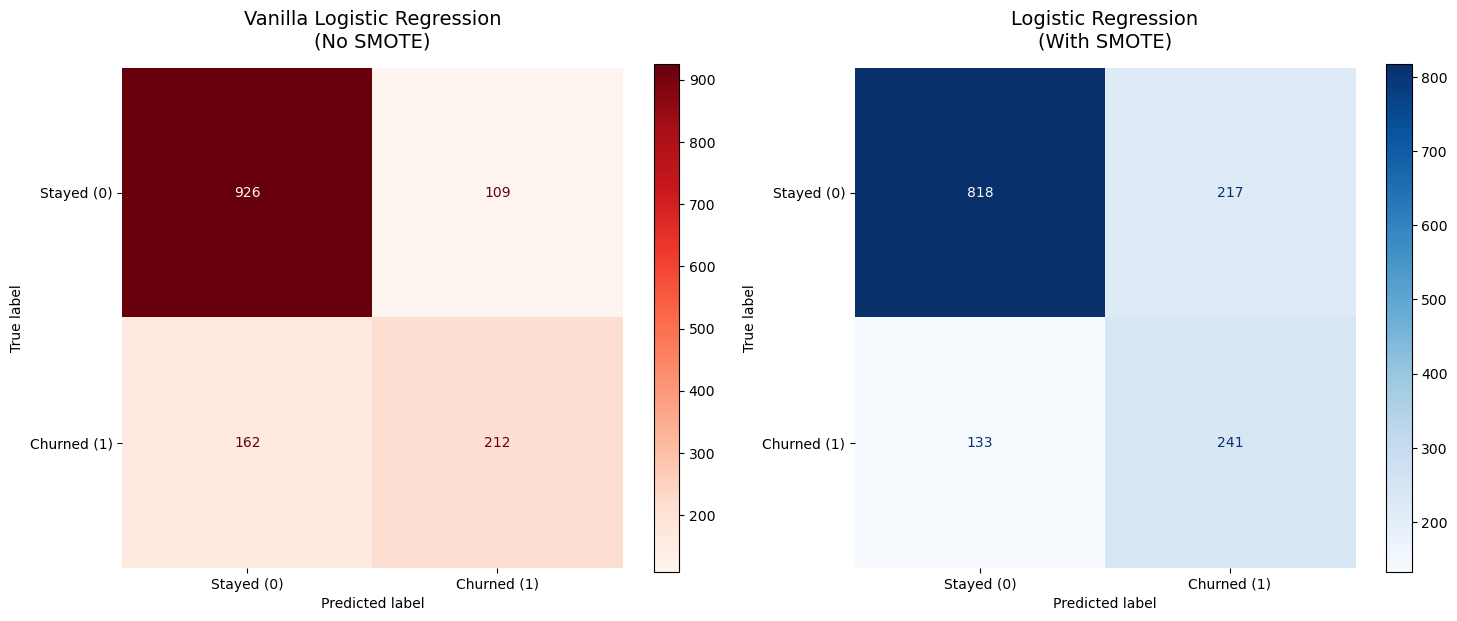

VANILLA REPORT (No SMOTE)
              precision  recall  f1-score  support
Stayed (0)         0.85    0.89      0.87   1035.0
Churned (1)        0.66    0.57      0.61    374.0
macro avg          0.76    0.73      0.74   1409.0
weighted avg       0.80    0.81      0.80   1409.0

SMOTE REPORT
              precision  recall  f1-score  support
Stayed (0)         0.86    0.79      0.82   1035.0
Churned (1)        0.53    0.64      0.58    374.0
macro avg          0.69    0.72      0.70   1409.0
weighted avg       0.77    0.75      0.76   1409.0


In [36]:
# --- Vanilla vs SMOTE (Logistic Regression) ---

# Assumes you already have:
# scaler, X_train, y_train, X_test, y_test
# X_train_res, y_train_res (from SMOTE)
# log_model (trained on X_train_res scaled), and y_pred (SMOTE preds on X_test_scaled)

# 1) Make sure TEST is scaled (same scaler used for both models)
X_test_scaled = scaler.transform(X_test)

# 2) Train "vanilla" logistic regression (NO SMOTE) using the SAME scaler
X_train_scaled_vanilla = scaler.transform(X_train)

log_vanilla = LogisticRegression(max_iter=1000, random_state=42)
log_vanilla.fit(X_train_scaled_vanilla, y_train)

# Vanilla predictions
y_pred_vanilla = log_vanilla.predict(X_test_scaled)

# 3) Plot confusion matrices side-by-side (no gridlines)
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Vanilla matrix
ConfusionMatrixDisplay.from_estimator(
    log_vanilla,
    X_test_scaled,
    y_test,
    cmap="Reds",
    ax=ax[0],
    display_labels=["Stayed (0)", "Churned (1)"],
    values_format="d"
)
ax[0].grid(False)
for spine in ax[0].spines.values():
    spine.set_visible(False)
ax[0].set_title("Vanilla Logistic Regression\n(No SMOTE)", fontsize=14, pad=15)

# SMOTE matrix (use your already-trained SMOTE model)
ConfusionMatrixDisplay.from_estimator(
    log_model,
    X_test_scaled,
    y_test,
    cmap="Blues",
    ax=ax[1],
    display_labels=["Stayed (0)", "Churned (1)"],
    values_format="d"
)
ax[1].grid(False)
for spine in ax[1].spines.values():
    spine.set_visible(False)
ax[1].set_title("Logistic Regression\n(With SMOTE)", fontsize=14, pad=15)

plt.tight_layout()
plt.show()

# 4) Print classification reports WITHOUT accuracy
def print_clean_report(y_true, y_pred, title):
    print("=" * 55)
    print(f"{title}")
    print("=" * 55)

    report = classification_report(
        y_true,
        y_pred,
        target_names=["Stayed (0)", "Churned (1)"],
        output_dict=True
    )

    # Remove accuracy row
    report.pop("accuracy", None)

    df_report = pd.DataFrame(report).transpose()
    print(df_report.round(2))
    print("=" * 55)

print_clean_report(y_test, y_pred_vanilla, "VANILLA REPORT (No SMOTE)")
print()
print_clean_report(y_test, y_pred, "SMOTE REPORT")

      Metric  Vanilla Model (No SMOTE)  SMOTE Model (Final)
0    ROC AUC                     0.842                0.802
1     PR AUC                     0.631                0.572
2  Precision                     0.660                0.526
3     Recall                     0.567                0.644
4   F1 Score                     0.610                0.579


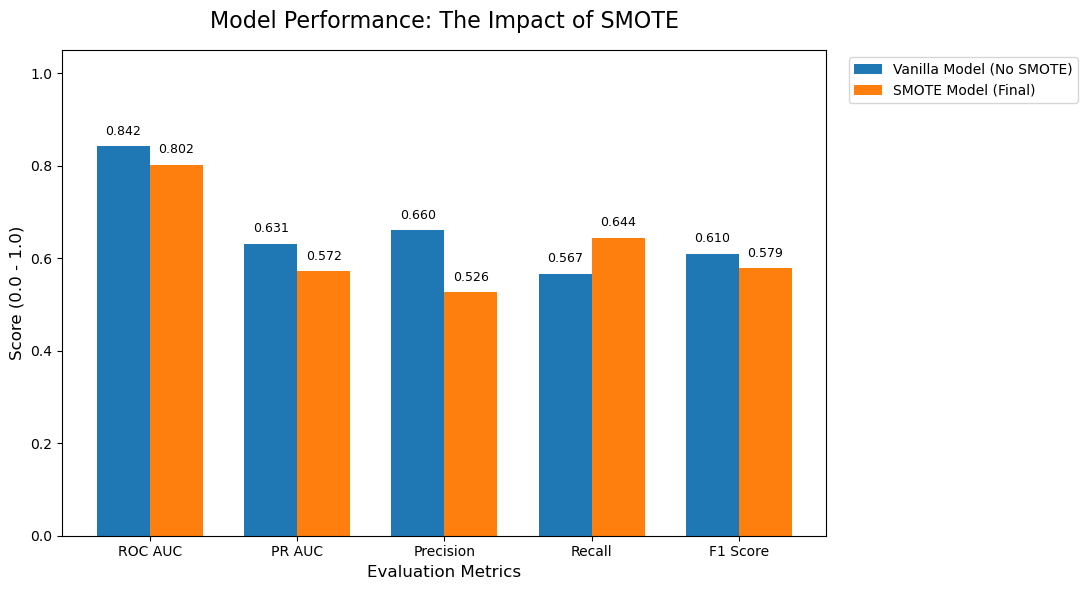

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    precision_score,
    recall_score,
    f1_score
)

# --- 1) Get probabilities (needed for ROC AUC and PR AUC) ---
# Both models must predict on the SAME scaled test set
y_prob_vanilla = log_vanilla.predict_proba(X_test_scaled)[:, 1]
y_prob_smote   = log_model.predict_proba(X_test_scaled)[:, 1]

# If you don't already have class predictions, compute them
y_pred_vanilla = log_vanilla.predict(X_test_scaled)
y_pred_smote   = log_model.predict(X_test_scaled)

# --- 2) Compute metrics ---
metrics_plot = ["ROC AUC", "PR AUC", "Precision", "Recall", "F1 Score"]

vanilla_plot = [
    roc_auc_score(y_test, y_prob_vanilla),
    average_precision_score(y_test, y_prob_vanilla),
    precision_score(y_test, y_pred_vanilla, pos_label=1),
    recall_score(y_test, y_pred_vanilla, pos_label=1),
    f1_score(y_test, y_pred_vanilla, pos_label=1),
]

smote_plot = [
    roc_auc_score(y_test, y_prob_smote),
    average_precision_score(y_test, y_prob_smote),
    precision_score(y_test, y_pred_smote, pos_label=1),
    recall_score(y_test, y_pred_smote, pos_label=1),
    f1_score(y_test, y_pred_smote, pos_label=1),
]

# --- 3) Prepare a DataFrame (optional, nice for printing) ---
df_plot = pd.DataFrame({
    "Metric": metrics_plot,
    "Vanilla Model (No SMOTE)": vanilla_plot,
    "SMOTE Model (Final)": smote_plot
})

print(df_plot.round(3))

# --- 4) Plot grouped bar chart (matplotlib) ---
x = np.arange(len(metrics_plot))
width = 0.36

fig, ax = plt.subplots(figsize=(11, 6))

bars1 = ax.bar(x - width/2, vanilla_plot, width, label="Vanilla Model (No SMOTE)")
bars2 = ax.bar(x + width/2, smote_plot, width, label="SMOTE Model (Final)")

# Add value labels on bars
for bars in (bars1, bars2):
    for b in bars:
        h = b.get_height()
        ax.annotate(
            f"{h:.3f}",
            xy=(b.get_x() + b.get_width()/2, h),
            xytext=(0, 6),
            textcoords="offset points",
            ha="center",
            va="bottom",
            fontsize=9
        )

ax.set_title("Model Performance: The Impact of SMOTE", fontsize=16, pad=16)
ax.set_ylabel("Score (0.0 - 1.0)", fontsize=12)
ax.set_xlabel("Evaluation Metrics", fontsize=12)
ax.set_ylim(0, 1.05)
ax.set_xticks(x)
ax.set_xticklabels(metrics_plot)
ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1))
ax.grid(False)

plt.tight_layout()

# Save the figure
plt.savefig("model_comparison_visual.png", dpi=200, bbox_inches="tight")
plt.show()

PR-AUC METRIC

PR AUC – Vanilla: 0.630
PR AUC – SMOTE:   0.571


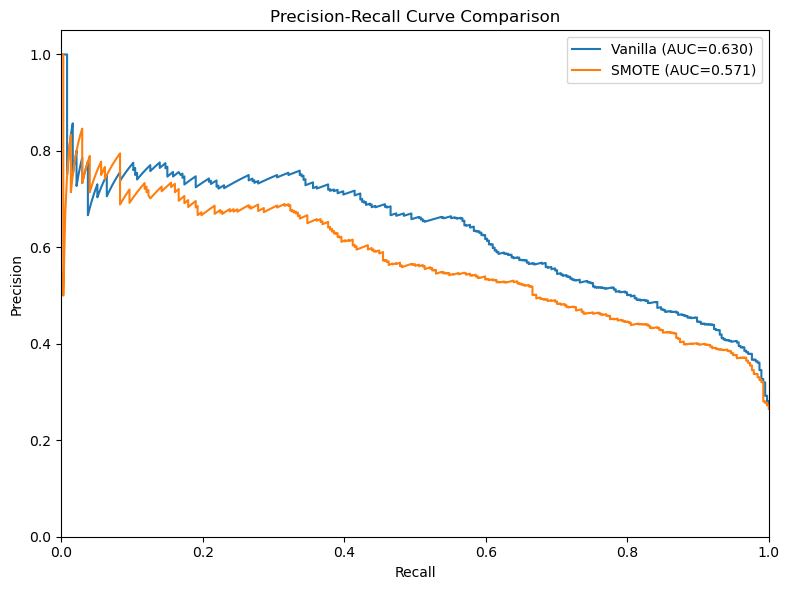

In [38]:
# --- PR-AUC Metric Comparison (Vanilla vs SMOTE) ---

from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# 1️ Get predicted probabilities (positive class = churn = 1)
y_proba_vanilla = log_vanilla.predict_proba(X_test_scaled)[:, 1]
y_proba_smote   = log_model.predict_proba(X_test_scaled)[:, 1]

# 2️ Compute Precision-Recall curves
prec_v, rec_v, _ = precision_recall_curve(y_test, y_proba_vanilla)
prec_s, rec_s, _ = precision_recall_curve(y_test, y_proba_smote)

# 3️ Compute PR-AUC
pr_auc_vanilla = auc(rec_v, prec_v)
pr_auc_smote   = auc(rec_s, prec_s)

print(f"PR AUC – Vanilla: {pr_auc_vanilla:.3f}")
print(f"PR AUC – SMOTE:   {pr_auc_smote:.3f}")

# 4️ Plot PR Curves
plt.figure(figsize=(8, 6))

plt.plot(rec_v, prec_v, label=f'Vanilla (AUC={pr_auc_vanilla:.3f})')
plt.plot(rec_s, prec_s, label=f'SMOTE (AUC={pr_auc_smote:.3f})')

plt.title('Precision-Recall Curve Comparison')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim(0, 1.05)
plt.xlim(0, 1.0)
plt.legend()
plt.grid(False)

plt.tight_layout()
plt.savefig('pr_curve_comparison.png', dpi=200, bbox_inches="tight")
plt.show()

ROC AUC vs PR AUC Comparison

In [39]:
from sklearn.metrics import (
    roc_auc_score,
    precision_recall_curve,
    auc
)

# IMPORTANT: use the scaled test set (same scaling used during training)
y_proba_vanilla = log_vanilla.predict_proba(X_test_scaled)[:, 1]
y_proba_smote   = log_model.predict_proba(X_test_scaled)[:, 1]

# ROC AUC
roc_vanilla = roc_auc_score(y_test, y_proba_vanilla)
roc_smote   = roc_auc_score(y_test, y_proba_smote)

# PR AUC
prec_v, rec_v, _ = precision_recall_curve(y_test, y_proba_vanilla)
prec_s, rec_s, _ = precision_recall_curve(y_test, y_proba_smote)

pr_auc_vanilla = auc(rec_v, prec_v)
pr_auc_smote   = auc(rec_s, prec_s)

print(f"ROC AUC – Vanilla: {roc_vanilla:.3f}")
print(f"ROC AUC – SMOTE:   {roc_smote:.3f}")
print(f"PR AUC  – Vanilla: {pr_auc_vanilla:.3f}")
print(f"PR AUC  – SMOTE:   {pr_auc_smote:.3f}")

ROC AUC – Vanilla: 0.842
ROC AUC – SMOTE:   0.802
PR AUC  – Vanilla: 0.630
PR AUC  – SMOTE:   0.571


CALCULATE MCC (Matthews Correlation Coefficient)

In [40]:
# --- CALCULATE MCC (Matthews Correlation Coefficient) ---

from sklearn.metrics import matthews_corrcoef

# Ensure predictions exist (use scaled test set)
y_pred_vanilla = log_vanilla.predict(X_test_scaled)
y_pred_smote   = log_model.predict(X_test_scaled)

# Calculate MCC for both models
mcc_vanilla = matthews_corrcoef(y_test, y_pred_vanilla)
mcc_smote   = matthews_corrcoef(y_test, y_pred_smote)

print("=" * 70)
print("MCC COMPARISON (Churn Prediction)")
print("=" * 70)

print(f"\nVanilla Model MCC:  {mcc_vanilla:.4f}")
print(f"SMOTE Model MCC:    {mcc_smote:.4f}")
print(f"Improvement:        {mcc_smote - mcc_vanilla:+.4f}")

print("\nINTERPRETATION:")

if mcc_smote > 0.7:
    print(f"   Excellent MCC ({mcc_smote:.3f}) - Strong predictive quality")
elif mcc_smote > 0.5:
    print(f"   Good MCC ({mcc_smote:.3f}) - Solid predictive quality")
elif mcc_smote > 0.3:
    print(f"   Moderate MCC ({mcc_smote:.3f}) - Room for improvement")
else:
    print(f"   Low MCC ({mcc_smote:.3f}) - Model needs improvement")

print("\nMCC Scale Reference:")
print("   +1.0 = Perfect prediction")
print("   +0.7 = Strong correlation")
print("   +0.5 = Moderate correlation")
print("   +0.3 = Weak correlation")
print("    0.0 = No better than random")
print("   -1.0 = Total disagreement")

MCC COMPARISON (Churn Prediction)

Vanilla Model MCC:  0.4859
SMOTE Model MCC:    0.4098
Improvement:        -0.0761

INTERPRETATION:
   Moderate MCC (0.410) - Room for improvement

MCC Scale Reference:
   +1.0 = Perfect prediction
   +0.7 = Strong correlation
   +0.5 = Moderate correlation
   +0.3 = Weak correlation
    0.0 = No better than random
   -1.0 = Total disagreement


COMPLETE METRICS COMPARISON (INCLUDING MCC)

In [41]:
# --- COMPLETE METRICS COMPARISON (INCLUDING MCC) ---

import pandas as pd
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    matthews_corrcoef, roc_auc_score,
    precision_recall_curve, auc
)

# 1) Ensure predictions exist (use the SAME scaled test set)
try:
    y_pred_vanilla
except NameError:
    y_pred_vanilla = log_vanilla.predict(X_test_scaled)

try:
    y_pred
except NameError:
    y_pred = log_model.predict(X_test_scaled)  # SMOTE model predictions

# 2) Probabilities for ROC/PR metrics
y_proba_vanilla = log_vanilla.predict_proba(X_test_scaled)[:, 1]
y_proba_smote   = log_model.predict_proba(X_test_scaled)[:, 1]

# 3) ROC AUC
roc_vanilla = roc_auc_score(y_test, y_proba_vanilla)
roc_smote   = roc_auc_score(y_test, y_proba_smote)

# 4) PR AUC
prec_v_curve, rec_v_curve, _ = precision_recall_curve(y_test, y_proba_vanilla)
prec_s_curve, rec_s_curve, _ = precision_recall_curve(y_test, y_proba_smote)
pr_auc_vanilla = auc(rec_v_curve, prec_v_curve)
pr_auc_smote   = auc(rec_s_curve, prec_s_curve)

# 5) Precision / Recall / F1 (positive class = churn = 1)
precision_v = precision_score(y_test, y_pred_vanilla, pos_label=1)
recall_v    = recall_score(y_test, y_pred_vanilla, pos_label=1)
f1_v        = f1_score(y_test, y_pred_vanilla, pos_label=1)

precision_s = precision_score(y_test, y_pred, pos_label=1)
recall_s    = recall_score(y_test, y_pred, pos_label=1)
f1_s        = f1_score(y_test, y_pred, pos_label=1)

# 6) MCC
mcc_vanilla = matthews_corrcoef(y_test, y_pred_vanilla)
mcc_smote   = matthews_corrcoef(y_test, y_pred)

# 7) Build comparison table
metrics_comparison = pd.DataFrame({
    "Metric": ["ROC AUC", "PR AUC", "Precision", "Recall", "F1 Score", "MCC"],
    "Vanilla": [roc_vanilla, pr_auc_vanilla, precision_v, recall_v, f1_v, mcc_vanilla],
    "SMOTE":   [roc_smote,   pr_auc_smote,   precision_s, recall_s, f1_s, mcc_smote],
})

metrics_comparison["Difference"] = metrics_comparison["SMOTE"] - metrics_comparison["Vanilla"]
metrics_comparison["Improvement %"] = metrics_comparison.apply(
    lambda r: (r["Difference"] / r["Vanilla"] * 100) if r["Vanilla"] != 0 else float("nan"),
    axis=1
)

print("=" * 80)
print("COMPLETE METRICS COMPARISON")
print("=" * 80)
print(metrics_comparison.round(4).to_string(index=False))
print("=" * 80)

COMPLETE METRICS COMPARISON
   Metric  Vanilla  SMOTE  Difference  Improvement %
  ROC AUC   0.8418 0.8023     -0.0396        -4.7005
   PR AUC   0.6302 0.5708     -0.0594        -9.4239
Precision   0.6604 0.5262     -0.1342       -20.3252
   Recall   0.5668 0.6444      0.0775        13.6792
 F1 Score   0.6101 0.5793     -0.0307        -5.0396
      MCC   0.4859 0.4098     -0.0761       -15.6557




Which metric is “the most important” in churn?
It depends on what hurts you most:
A) You want to catch as many churners as possible (avoid losing customers)
Prioritize: Recall (Churn=1) and PR-AUC
Why: churn is usually the minority class; PR-AUC and Recall better measure how well you detect “1”.
B) You want to avoid bothering customers who won’t churn (expensive campaigns / limited call center capacity)
Prioritize: Precision (Churn=1) and PR-AUC
Why: Precision penalizes false positives (saying “will churn” when they won’t).
C) You want a robust balance with imbalanced classes
Prioritize: MCC (a very good “overall” metric for imbalance) + PR-AUC


In [42]:
# --- Decide best model based on business objective ---

import numpy as np

# Choose your objective: "recall", "precision", or "balanced"
objective = "recall"  # change to: "precision" or "balanced"

# Helper: get a metric value from the comparison table
def get_metric(df, metric_name, model_col):
    row = df.loc[df["Metric"] == metric_name, model_col]
    return float(row.values[0]) if len(row) else np.nan

# Pull key metrics
van_recall = get_metric(metrics_comparison, "Recall", "Vanilla")
smo_recall = get_metric(metrics_comparison, "Recall", "SMOTE")

van_prec = get_metric(metrics_comparison, "Precision", "Vanilla")
smo_prec = get_metric(metrics_comparison, "Precision", "SMOTE")

van_prauc = get_metric(metrics_comparison, "PR AUC", "Vanilla")
smo_prauc = get_metric(metrics_comparison, "PR AUC", "SMOTE")

van_mcc = get_metric(metrics_comparison, "MCC", "Vanilla")
smo_mcc = get_metric(metrics_comparison, "MCC", "SMOTE")

# Decision rules (simple + practical)
if objective == "recall":
    # Prefer higher recall; break ties with PR-AUC
    winner = "SMOTE" if (smo_recall > van_recall) or (smo_recall == van_recall and smo_prauc > van_prauc) else "Vanilla"
    reason = f"Recall is priority. Vanilla={van_recall:.3f}, SMOTE={smo_recall:.3f}. PR-AUC Vanilla={van_prauc:.3f}, SMOTE={smo_prauc:.3f}"

elif objective == "precision":
    # Prefer higher precision; break ties with PR-AUC
    winner = "SMOTE" if (smo_prec > van_prec) or (smo_prec == van_prec and smo_prauc > van_prauc) else "Vanilla"
    reason = f"Precision is priority. Vanilla={van_prec:.3f}, SMOTE={smo_prec:.3f}. PR-AUC Vanilla={van_prauc:.3f}, SMOTE={smo_prauc:.3f}"

elif objective == "balanced":
    # Prefer higher MCC; break ties with PR-AUC
    winner = "SMOTE" if (smo_mcc > van_mcc) or (smo_mcc == van_mcc and smo_prauc > van_prauc) else "Vanilla"
    reason = f"MCC is priority. Vanilla={van_mcc:.3f}, SMOTE={smo_mcc:.3f}. PR-AUC Vanilla={van_prauc:.3f}, SMOTE={smo_prauc:.3f}"

else:
    raise ValueError("objective must be one of: 'recall', 'precision', 'balanced'")

print("=" * 70)
print("MODEL RECOMMENDATION")
print("=" * 70)
print(f"Objective: {objective.upper()}")
print(f"Recommended model: {winner}")
print(f"Reason: {reason}")
print("=" * 70)

MODEL RECOMMENDATION
Objective: RECALL
Recommended model: SMOTE
Reason: Recall is priority. Vanilla=0.567, SMOTE=0.644. PR-AUC Vanilla=0.630, SMOTE=0.571


UPDATED METRICS BAR CHART (WITH MCC)

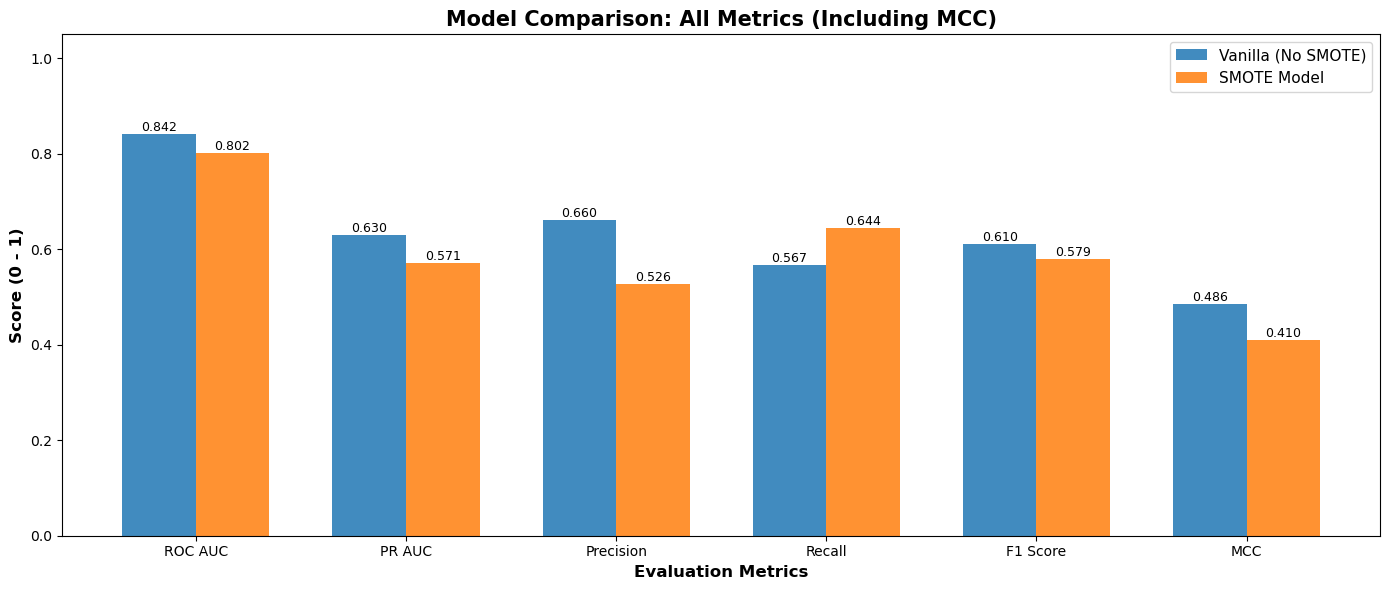

Updated metrics chart with MCC successfully generated!


In [43]:
# --- UPDATED METRICS BAR CHART (INCLUDING MCC) ---

import numpy as np
# matplotlib.pyplot as plt already imported earlier

metrics = ['ROC AUC', 'PR AUC', 'Precision', 'Recall', 'F1 Score', 'MCC']

# Ensure numeric scalars
vanilla_scores = [
    float(roc_vanilla),
    float(pr_auc_vanilla),
    float(precision_v),
    float(recall_v),
    float(f1_v),
    float(mcc_vanilla)
]

smote_scores = [
    float(roc_smote),
    float(pr_auc_smote),
    float(precision_s),
    float(recall_s),
    float(f1_s),
    float(mcc_smote)
]

fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(len(metrics))
width = 0.35

bars1 = ax.bar(
    x - width/2,
    vanilla_scores,
    width,
    label='Vanilla (No SMOTE)',
    alpha=0.85
)

bars2 = ax.bar(
    x + width/2,
    smote_scores,
    width,
    label='SMOTE Model',
    alpha=0.85
)

ax.set_xlabel('Evaluation Metrics', fontsize=12, fontweight='bold')
ax.set_ylabel('Score (0 - 1)', fontsize=12, fontweight='bold')
ax.set_title('Model Comparison: All Metrics (Including MCC)',
             fontsize=15, fontweight='bold')

ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim([0, 1.05])
ax.legend(fontsize=11)
ax.grid(False)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2.,
            height,
            f'{height:.3f}',
            ha='center',
            va='bottom',
            fontsize=9
        )

plt.tight_layout()
plt.savefig('metrics_comparison_with_mcc.png', dpi=200, bbox_inches='tight')
plt.show()

print("Updated metrics chart with MCC successfully generated!")

Import the models


In [44]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

Train the tree models (using the same train/test and SMOTE)

In [58]:
# Recreate clean split (NO scaling, NO SMOTE)

X = df.drop("churn", axis=1)
y = df["churn"]

from sklearn.model_selection import train_test_split

X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [59]:
scale_pos_weight = (y_train_clean == 0).sum() / (y_train_clean == 1).sum()
print(scale_pos_weight)

2.768561872909699


In [71]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

# 1) Start from your clean df
df = pd.read_csv("customer_churn_clean.csv")

# 2) Drop ID column
df = df.drop(columns=["customerid"], errors="ignore")

# 3) One-hot encode categorical columns
df_enc = pd.get_dummies(df, drop_first=True)

# 4) Split
X = df_enc.drop("churn", axis=1)
y = df_enc["churn"]

X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# 5) Class weight for imbalance
scale_pos_weight = (y_train_clean == 0).sum() / (y_train_clean == 1).sum()

# 6) train random

rf_model = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    class_weight="balanced",  # 🔥 IMPORTANT
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_clean, y_train_clean)

# 7) Train XGBoost (NO scaling, NO SMOTE)
xgb_model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
    eval_metric="logloss"
)

xgb_model.fit(X_train_clean, y_train_clean)

print("trained successfully with one-hot encoded data.")

trained successfully with one-hot encoded data.


Compute probabilities and metrics the same way

In [72]:
import pandas as pd
import numpy as np

from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    matthews_corrcoef, roc_auc_score,
    precision_recall_curve, auc
)

# Helper: compute all metrics consistently (positive class = churn = 1)
def get_metrics(model, X, y):
    y_pred = model.predict(X)

    # Probabilities (preferred) or scores (fallback)
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X)[:, 1]
    elif hasattr(model, "decision_function"):
        y_score = model.decision_function(X)
    else:
        raise AttributeError("Model must have predict_proba or decision_function to compute ROC/PR AUC.")

    precision = precision_score(y, y_pred, pos_label=1)
    recall    = recall_score(y, y_pred, pos_label=1)
    f1        = f1_score(y, y_pred, pos_label=1)
    mcc       = matthews_corrcoef(y, y_pred)
    roc       = roc_auc_score(y, y_score)

    prec_curve, rec_curve, _ = precision_recall_curve(y, y_score)
    pr_auc = auc(rec_curve, prec_curve)

    return precision, recall, f1, mcc, roc, pr_auc

# --- Compute metrics ---
# Logistic Regression (SMOTE) -> uses scaled test set
lr_precision, lr_recall, lr_f1, lr_mcc, lr_roc, lr_pr = get_metrics(log_model, X_test_scaled, y_test)

# Random Forest and XGBoost -> use unscaled test set
rf_precision, rf_recall, rf_f1, rf_mcc, rf_roc, rf_pr = get_metrics(rf_model,  X_test, y_test)
xg_precision, xg_recall, xg_f1, xg_mcc, xg_roc, xg_pr = get_metrics(xgb_model, X_test, y_test)

metrics = ['ROC AUC', 'PR AUC', 'Precision', 'Recall', 'F1 Score', 'MCC']

metrics_comparison_all = pd.DataFrame({
    'Metric': metrics,
    'LogReg (SMOTE)': [
        float(lr_roc),
        float(lr_pr),
        float(lr_precision),
        float(lr_recall),
        float(lr_f1),
        float(lr_mcc)
    ],
    'Random Forest (SMOTE train)': [
        float(rf_roc),
        float(rf_pr),
        float(rf_precision),
        float(rf_recall),
        float(rf_f1),
        float(rf_mcc)
    ],
    'XGBoost (SMOTE train)': [
        float(xg_roc),
        float(xg_pr),
        float(xg_precision),
        float(xg_recall),
        float(xg_f1),
        float(xg_mcc)
    ]
})

print(metrics_comparison_all.round(3).to_string(index=False))

   Metric  LogReg (SMOTE)  Random Forest (SMOTE train)  XGBoost (SMOTE train)
  ROC AUC           0.799                        0.827                  0.832
   PR AUC           0.564                        0.622                  0.636
Precision           0.424                        0.625                  0.530
   Recall           0.845                        0.481                  0.746
 F1 Score           0.564                        0.544                  0.620
      MCC           0.380                        0.413                  0.463


In [73]:
import numpy as np

y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

print("Min prob:", np.min(y_proba_xgb))
print("Max prob:", np.max(y_proba_xgb))
print("Mean prob:", np.mean(y_proba_xgb))

Min prob: 0.00020072435
Max prob: 0.9836731
Mean prob: 0.37441045


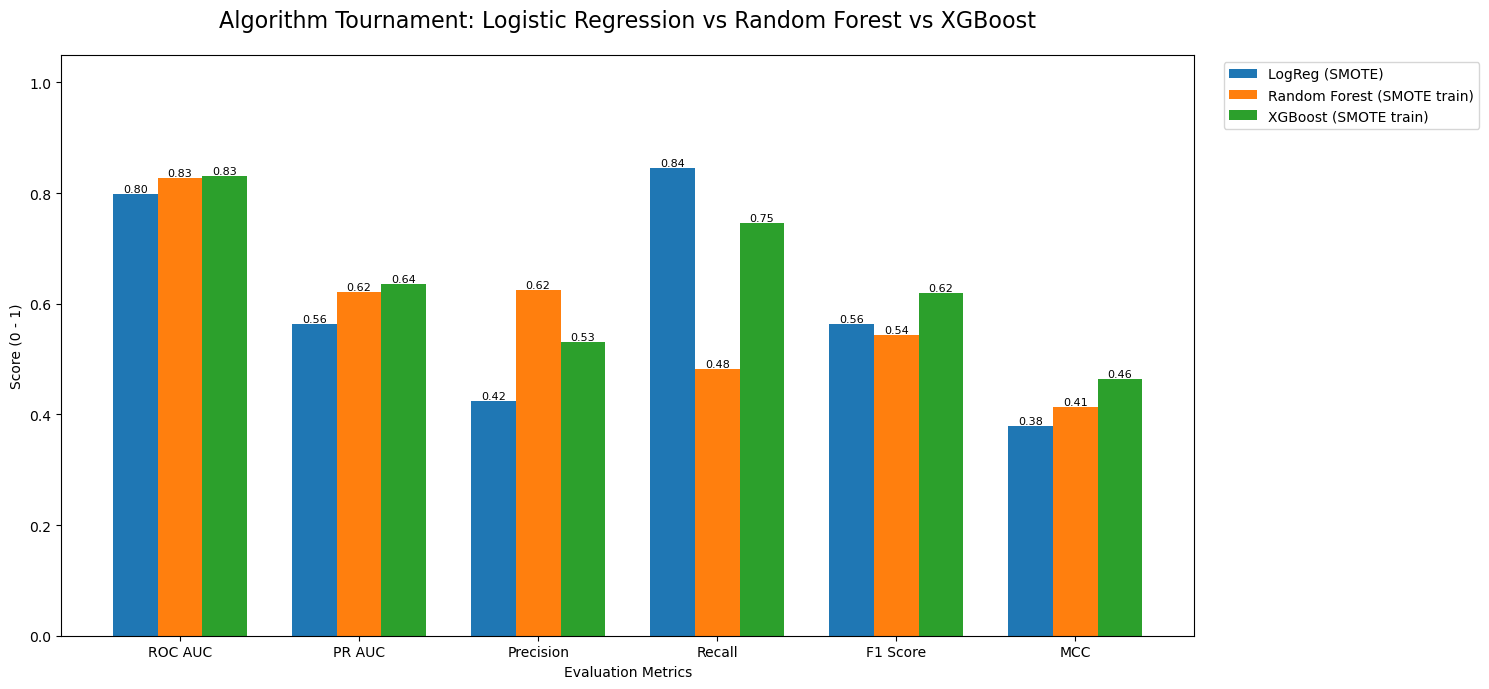

In [74]:
# --- Algorithm Tournament: LogReg vs RF vs XGBoost ---

import numpy as np
import matplotlib.pyplot as plt

# Melt-like structure manually for matplotlib grouped bars
metrics = metrics_comparison_all["Metric"].values
models = metrics_comparison_all.columns[1:]  # exclude 'Metric'

x = np.arange(len(metrics))
width = 0.25

fig, ax = plt.subplots(figsize=(15, 7))

# Extract scores
scores_lr  = metrics_comparison_all[models[0]].values
scores_rf  = metrics_comparison_all[models[1]].values
scores_xgb = metrics_comparison_all[models[2]].values

bars1 = ax.bar(x - width, scores_lr,  width, label=models[0])
bars2 = ax.bar(x,         scores_rf,  width, label=models[1])
bars3 = ax.bar(x + width, scores_xgb, width, label=models[2])

# Add value labels
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2.,
                height,
                f'{height:.2f}',
                ha='center',
                va='bottom',
                fontsize=8
            )

ax.set_title(
    'Algorithm Tournament: Logistic Regression vs Random Forest vs XGBoost',
    fontsize=16,
    pad=20
)

ax.set_ylabel('Score (0 - 1)')
ax.set_xlabel('Evaluation Metrics')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1.05)
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))
ax.grid(False)

plt.tight_layout()
plt.savefig("algorithm_tournament_comparison.png", dpi=200, bbox_inches="tight")
plt.show()